In [ ]:
# OPTION 1
# Run this if no existing libraries are there in Google drive
from google.colab import drive
drive.mount('/content/drive')

# Step 1: Create a directory for your custom library installations
!mkdir -p /content/drive/MyDrive/colab_libraries

# Step 2: Install compatible versions of numpy, scipy, and other required libraries
# Force reinstall to ensure specific versions
!pip install numpy==1.23.5 --target=/content/drive/MyDrive/colab_libraries --force-reinstall
!pip install scipy==1.10.1 --target=/content/drive/MyDrive/colab_libraries --force-reinstall
!pip install tensorflow --target=/content/drive/MyDrive/colab_libraries --force-reinstall
!pip install xgboost albumentations opencv-python-headless tqdm --target=/content/drive/MyDrive/colab_libraries

# Step 3: Uninstall any libraries known to cause version conflicts, like jax and jaxlib
!pip uninstall -y jax jaxlib

# Step 4: Upgrade or install additional dependencies as needed
!pip install joblib --upgrade --target=/content/drive/MyDrive/colab_libraries

# Step 5: Append the custom libraries directory to sys.path to ensure they are found
import sys
sys.path.append('/content/drive/MyDrive/colab_libraries')

# IMPORTANT: Monitor the console output to ensure jax and jaxlib are fully uninstalled before proceeding.

### WARNING! when running this cell, wait until the JAXLIB is uninstalled BEFORE allowing RESTART!!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ERROR: Operation cancelled by user
  Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.87 requires jax>=0.4.27, which is not installed.
chex 0.1.87 requires jaxlib>=0.4.27, which is not installed.
dopamine-rl 4.0.9 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.0.9 requires jaxlib>=0.1.51, which is not installed.
flax 0.8.5 re

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)


In [ ]:
# OPTION 2
# Mount Google Drive (Run this when there is an existing libraries saved)
from google.colab import drive
drive.mount('/content/drive')

# Append custom library path to sys.path
import sys
sys.path.append('/content/drive/MyDrive/colab_libraries')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 1: Import Libraries and Load Pre-trained Model for Feature Extraction
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, classification_report
from albumentations import Compose, HorizontalFlip, Rotate, RandomBrightnessContrast, Normalize
from tqdm import tqdm
import joblib

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Step 2: Enable GPU and parallel processing in TensorFlow
# Configure TensorFlow to use GPU and allocate memory dynamically
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU memory growth enabled for:", physical_devices)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU devices found, using CPU.")

# Enable TensorFlow threading for efficient CPU utilisation
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(8)


GPU memory growth enabled for: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Step 3: Paths for images and masks
covid_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/COVID19_xrays"
noncovid_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/NonCOVID19_xrays"
normal_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/Normal_xrays"

covid_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_COVID19"
noncovid_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_NonCOVID"
normal_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_Normal"

In [ ]:
# Count the number of files in each path
#paths = [covid_path, noncovid_path, normal_path, covid_mask_path, noncovid_mask_path, normal_mask_path]
#labels = ['COVID X-rays', 'Non-COVID X-rays', 'Normal X-rays', 'COVID Masks', 'Non-COVID Masks', 'Normal Masks']

#counts = [[label, len(os.listdir(path))] for label, path in zip(labels, paths)]
#counts_df = pd.DataFrame(counts, columns=['Path', 'File Count'])
#print(counts_df)

In [ ]:
# Step 4: Define Functions for Loading, Masking, and Augmenting Images
# (using only 500 images for each category)
def load_images_and_masks(image_dir, mask_dir, img_size=(256, 256), sample_size=500):
    print(f"Loading images and masks from {image_dir} and {mask_dir}")
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))[:sample_size]
    mask_files = sorted(os.listdir(mask_dir))[:sample_size]

    for img_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files), desc=f"Loading {image_dir}"):
        # Load image and mask
        img = cv2.imread(os.path.join(image_dir, img_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

        # Resize to target dimensions
        img = cv2.resize(img, img_size)
        mask = cv2.resize(mask, img_size)

        # Normalize image and apply mask
        img = img / 255.0  # Normalize pixel values
        masked_img = cv2.bitwise_and(img, img, mask=mask)  # Apply lung mask

        images.append(masked_img)
        masks.append(mask)

    print(f"Loaded {len(images)} images and {len(masks)} masks from {image_dir}")
    return np.array(images), np.array(masks)

# Define augmentations
augmentations = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=10, p=0.5),
    RandomBrightnessContrast(p=0.5),
    Normalize(mean=(0.5,), std=(0.5,))
])

def augment_image(image):
    print("Applying augmentations to image")
    augmented = augmentations(image=image)
    return augmented['image']


In [ ]:
# Step 5: Load and Process the Data
# Load 10 images and masks per category
print("Loading and processing data for COVID, Non-COVID, and Normal categories")
covid_images, covid_masks = load_images_and_masks(covid_path, covid_mask_path, sample_size=500)
noncovid_images, noncovid_masks = load_images_and_masks(noncovid_path, noncovid_mask_path, sample_size=500)
normal_images, normal_masks = load_images_and_masks(normal_path, normal_mask_path, sample_size=500)
print("Combining images and labels for all categories")
X = np.concatenate([covid_images, noncovid_images, normal_images])
y = np.concatenate([np.zeros(len(covid_images)), np.ones(len(noncovid_images)), np.full(len(normal_images), 2)])


Loading and processing data for COVID, Non-COVID, and Normal categories
Loading images and masks from /content/drive/MyDrive/extracted_files/Pre-processing data/COVID19_xrays and /content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_COVID19


Loading /content/drive/MyDrive/extracted_files/Pre-processing data/COVID19_xrays: 100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


Loaded 500 images and 500 masks from /content/drive/MyDrive/extracted_files/Pre-processing data/COVID19_xrays
Loading images and masks from /content/drive/MyDrive/extracted_files/Pre-processing data/NonCOVID19_xrays and /content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_NonCOVID


Loading /content/drive/MyDrive/extracted_files/Pre-processing data/NonCOVID19_xrays: 100%|██████████| 500/500 [04:52<00:00,  1.71it/s]


Loaded 500 images and 500 masks from /content/drive/MyDrive/extracted_files/Pre-processing data/NonCOVID19_xrays
Loading images and masks from /content/drive/MyDrive/extracted_files/Pre-processing data/Normal_xrays and /content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_Normal


Loading /content/drive/MyDrive/extracted_files/Pre-processing data/Normal_xrays: 100%|██████████| 500/500 [04:38<00:00,  1.79it/s]


Loaded 500 images and 500 masks from /content/drive/MyDrive/extracted_files/Pre-processing data/Normal_xrays
Combining images and labels for all categories


In [ ]:
# Step 6: Feature Extraction with ResNet50
print("Loading ResNet50 model for feature extraction")
# Load the ResNet50 model for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the model layers

# Prepare a new model up to the last convolutional layer
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(images):
    print(f"Extracting features for {len(images)} images")
    # Ensure images are 3-channel (RGB) as required by ResNet
    images = np.stack([np.repeat(img[..., np.newaxis], 3, -1) for img in images])
    try:
        features = feature_extractor.predict(images, batch_size=256)  # Increase batch size to utilize more GPU RAM
    except tf.errors.ResourceExhaustedError:
        print("Resource exhausted error caught, reducing batch size to 128")
        try:
            features = feature_extractor.predict(images, batch_size=128)  # Reduce to 128 if memory is insufficient
        except tf.errors.ResourceExhaustedError:
            print("Resource exhausted error caught again, reducing batch size to 32")
            features = feature_extractor.predict(images, batch_size=32)  # Reduce to 32 if memory is still insufficient
    # Reshape features to 2D for compatibility with XGBoost
    features = features.reshape(features.shape[0], -1)
    print(f"Extracted features shape: {features.shape}")
    return features

Loading ResNet50 model for feature extraction
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Step 7: Prepare Data and Extract Features
print("Splitting data into training, validation, and test sets")
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Extract features
print("Extracting features for training, validation, and test sets")
# Apply augmentation to the original images first, then extract features
X_train_augmented = np.array([augment_image(img) for img in X_train])
X_train_features = extract_features(X_train_augmented)  # Apply augmentation to training set
X_val_features = extract_features(X_val)
X_test_features = extract_features(X_test)

Splitting data into training, validation, and test sets
Extracting features for training, validation, and test sets
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentations to image
Applying augmentatio

In [ ]:
# Step 8: Hyperparameter Tuning with RandomizedSearchCV using Multiprocessing
print("Starting hyperparameter tuning with RandomizedSearchCV")
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [2, 3],  # Limiting depth options
    'learning_rate': [0.05, 0.1, 0.2],  # Fewer options for learning rate
    'n_estimators': [10, 30],  # Reducing number of estimators from 100, 200, 300 to prevent memory loss issues
    'gamma': [1e-8, 1e-2],  # Limiting gamma to fewer values
    'reg_alpha': [1e-8, 1e-2],  # Fewer regularization options
    'reg_lambda': [1e-8, 1e-2],  # Fewer regularization options
    'subsample': [0.7, 1.0],  # Only two options for subsampling
    'colsample_bytree': [0.7, 1.0]  # Only two options for column sampling
}

# Initialize the XGBoost model with updated GPU support
model = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='mlogloss')

# Set up RandomizedSearchCV with n_jobs=-1 for multiprocessing
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=5, scoring='accuracy', n_jobs=-1, cv=2, verbose=2, random_state=42, pre_dispatch='2*n_jobs',error_score='raise')

# Fit RandomizedSearchCV
print("Fitting RandomizedSearchCV to find the best parameters")
random_search.fit(X_train_features, y_train)

# Get the best parameters from RandomizedSearchCV
# Save best parameters to a file for later use
best_params = random_search.best_params_
print("Best hyperparameters from RandomizedSearchCV:", best_params)

# Save Best Parameters
joblib.dump(best_params, '/content/best_params.pkl')

Starting hyperparameter tuning with RandomizedSearchCV
Fitting RandomizedSearchCV to find the best parameters
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best hyperparameters from RandomizedSearchCV: {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 1e-08, 'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 1e-08, 'colsample_bytree': 1.0}


['/content/best_params.pkl']

In [ ]:
# Step 9: Train Final Model with Best Hyperparameters and Evaluate
print("Training final model with best parameters")

# Check if best_params is already defined in previous cell; if not, load from file if it exists
try:
    best_params
except NameError:
    # best_params is not defined, attempt to load saved parameters
    if os.path.exists('/content/best_params.pkl'):
        best_params = joblib.load('/content/best_params.pkl')

    else:
        raise NameError("best_params is not defined and no saved parameters were found.")

# Initialize the final model with best parameters
final_model = xgb.XGBClassifier(**best_params, eval_metric='mlogloss', n_jobs=-1)
final_model.fit(X_train_features, y_train, eval_set=[(X_val_features, y_val)], verbose=False)

# Save the trained model
print("Saving the trained final model in pkl")
joblib.dump(final_model, '/content/XGBoost_model.pkl')

# Predict on validation and test sets
print("Predicting on validation and test sets")
val_preds = final_model.predict(X_val_features)
test_preds = final_model.predict(X_test_features)

# Evaluate performance
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(y_test, test_preds))

Training final model with best parameters
Saving the trained final model in pkl
Predicting on validation and test sets
Validation Accuracy: 0.29333333333333333
Test Accuracy: 0.29333333333333333

Classification Report on Test Data:
               precision    recall  f1-score   support

         0.0       0.31      0.61      0.41        75
         1.0       0.29      0.19      0.23        75
         2.0       0.22      0.08      0.12        75

    accuracy                           0.29       225
   macro avg       0.27      0.29      0.25       225
weighted avg       0.27      0.29      0.25       225



Training final model with evaluation tracking for boosting round convergence


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.05664	validation_1-mlogloss:1.09580
[1]	validation_0-mlogloss:1.01748	validation_1-mlogloss:1.08431
[2]	validation_0-mlogloss:0.97716	validation_1-mlogloss:1.08730
[3]	validation_0-mlogloss:0.94485	validation_1-mlogloss:1.09949
[4]	validation_0-mlogloss:0.91287	validation_1-mlogloss:1.08420
[5]	validation_0-mlogloss:0.88146	validation_1-mlogloss:1.09190
[6]	validation_0-mlogloss:0.85389	validation_1-mlogloss:1.08658
[7]	validation_0-mlogloss:0.82918	validation_1-mlogloss:1.08469
[8]	validation_0-mlogloss:0.80671	validation_1-mlogloss:1.08882
[9]	validation_0-mlogloss:0.78480	validation_1-mlogloss:1.09600
[10]	validation_0-mlogloss:0.76285	validation_1-mlogloss:1.09051
[11]	validation_0-mlogloss:0.74289	validation_1-mlogloss:1.09506
[12]	validation_0-mlogloss:0.72439	validation_1-mlogloss:1.09437
[13]	validation_0-mlogloss:0.70756	validation_1-mlogloss:1.09994
[14]	validation_0-mlogloss:0.69055	validation_1-mlogloss:1.09717
[15]	validation_0-mlogloss:0.67351	

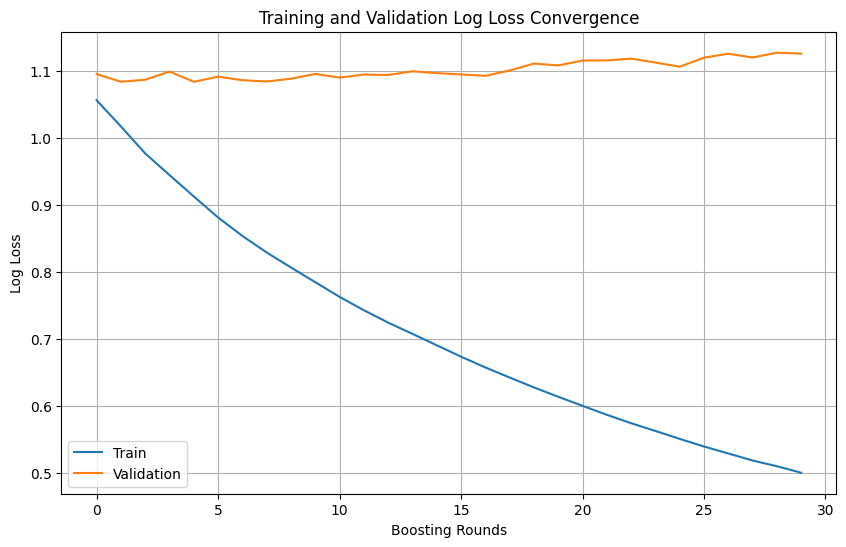

Model saved as well in 'XGBoost_model.json'


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Step 10: Plot Boosting Round Convergence
print("Training final model with evaluation tracking for boosting round convergence")

# Initialize the final model with best parameters and set GPU options
final_model = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    **best_params,
    use_label_encoder=False,
    n_jobs=-1,
    eval_metric='mlogloss'  # Specify log loss as the evaluation metric
)

# Train the model with tracking of training and validation loss per boosting round
final_model.fit(
    X_train_features,
    y_train,
    eval_set=[(X_train_features, y_train), (X_val_features, y_val)],
    verbose=True  # Verbose output for tracking log loss at each round
)

# Extract evaluation metrics for plotting
metrics = final_model.evals_result()
train_loss = metrics['validation_0']['mlogloss']
val_loss = metrics['validation_1']['mlogloss']
rounds = len(train_loss)

# Plot the boosting round convergence for both training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(rounds), train_loss, label='Train')
plt.plot(range(rounds), val_loss, label='Validation')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Training and Validation Log Loss Convergence')
plt.legend()
plt.grid(True)
plt.show()

# Save the model to JSON format
final_model.save_model('/content/XGBoost_model.json')
print("Model saved as well in 'XGBoost_model.json'")
